# Challenge Data - Football: qui va gagner ?

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pour utiliser les donnés sur Google Drive
COLAB = False

In [24]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

In [25]:
if COLAB:
    base_path = '/content/drive/MyDrive/data-challenge'
else:
    base_path = './data'

path_player_away_train = f'{base_path}/Train_Data/train_away_player_statistics_df.csv'
path_player_home_train = f'{base_path}/Train_Data/train_home_player_statistics_df.csv'
path_team_away_train = f'{base_path}/Train_Data/train_away_team_statistics_df.csv'
path_team_home_train = f'{base_path}/Train_Data/train_home_team_statistics_df.csv'
path_target = f'{base_path}/Y_train_1rknArQ.csv'
path_target_sup = f'{base_path}/benchmark_and_extras/Y_train_supp.csv'

## Exploration des données

### Lecture des données

In [26]:
train_team_home = pd.read_csv(path_team_home_train, sep=',')
train_team_away = pd.read_csv(path_team_away_train, sep=',')

train_player_away = pd.read_csv(path_player_away_train, sep=',')
train_player_home = pd.read_csv(path_player_home_train, sep=',')

In [27]:
train_target = pd.read_csv(path_target, sep=',')
train_target_sup = pd.read_csv(path_target_sup, sep=',')

In [28]:
train_target

,ID,HOME_WINS,DRAW,AWAY_WINS
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,3,1,0,0
4,4,0,1,0
...,...,...,...,...
12298,12298,0,0,1
12299,12299,0,0,1
12300,12300,0,0,1
12301,12301,1,0,0


On va combiner les données des équipes

In [29]:
train_team_home.columns = 'HOME_' + train_team_home.columns
train_team_away.columns = 'AWAY_' + train_team_away.columns

In [30]:
# train_team =  pd.concat([train_team_home.iloc[:, 3:], train_team_away.iloc[:, 3:]],join='inner',axis=1)
train_team = pd.merge(train_team_home, train_team_away, left_on='HOME_ID', right_on='AWAY_ID', how='inner')

train_team['ID'] = train_team['HOME_ID'].combine_first(train_team['AWAY_ID'])

train_team = train_team.drop(columns=['HOME_ID', 'AWAY_ID'])

train_team.insert(0, 'ID', train_team.pop('ID'))
train_team.head()

,ID,HOME_LEAGUE,HOME_TEAM_NAME,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0


In [31]:
print(f'Dimension du dataset: {train_team.shape}')

Dimension du dataset: (12303, 285)


In [32]:
train_team

,ID,HOME_LEAGUE,HOME_TEAM_NAME,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
0,0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,NaN,2.0
4,4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,12298,League One,Southend United,4.0,2.0,3.0,4.0,7.0,4.0,4.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,NaN,2.0
12299,12299,Liga Portugal,Boavista,4.0,2.0,3.0,1.0,5.0,1.0,1.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,12300,Bundesliga,Schalke 04,4.0,3.0,5.0,3.0,5.0,1.0,1.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0
12301,12301,League One,Fleetwood Town,2.0,NaN,1.0,1.0,NaN,NaN,NaN,...,2.0,0.0,NaN,0.0,8.0,3.0,1.0,2.0,NaN,6.0


In [33]:
train_target

,ID,HOME_WINS,DRAW,AWAY_WINS
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,3,1,0,0
4,4,0,1,0
...,...,...,...,...
12298,12298,0,0,1
12299,12299,0,0,1
12300,12300,0,0,1
12301,12301,1,0,0


### Analyse des données manquantes

En analysant les données manquantes sur les colonnes, on voit que la colonne avec le plus de données manquantes a un percentage de 27% de données manquantes 

In [35]:
column_missing_values = train_team.isna().mean().sort_values(ascending=False)
column_missing_values

HOME_TEAM_INJURIES_5_last_match_std             0.269690
AWAY_TEAM_INJURIES_5_last_match_std             0.269284
AWAY_TEAM_INJURIES_5_last_match_sum             0.238397
AWAY_TEAM_INJURIES_5_last_match_average         0.238316
HOME_TEAM_INJURIES_5_last_match_sum             0.238316
                                                  ...   
AWAY_TEAM_SHOTS_OFF_TARGET_season_sum           0.000000
AWAY_TEAM_ATTACKS_season_sum                    0.000000
AWAY_TEAM_ATTACKS_5_last_match_sum              0.000000
HOME_TEAM_SHOTS_OFF_TARGET_season_average       0.000000
AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_sum    0.000000
Length: 285, dtype: float64

In [36]:
print(f'Percentage de colonnes avec de données manquantes: {len(column_missing_values[column_missing_values > 0])*100/len(column_missing_values):.3f} %')

Percentage de colonnes avec de données manquantes: 82.807 %


En analysant sur les lignes, on voit qu'on a des lignes avec beaucoup de données manquantes (> 50%)

In [37]:
row_missing_values = train_team.isna().mean(axis=1).sort_values(ascending=False)
row_missing_values

5646     0.547368
10163    0.547368
4624     0.435088
835      0.428070
8538     0.428070
           ...   
4909     0.000000
4911     0.000000
4912     0.000000
4917     0.000000
4900     0.000000
Length: 12303, dtype: float64

In [38]:
print(f'Percentage de lignes avec de données manquantes: {len(row_missing_values[row_missing_values > 0])*100/len(row_missing_values):.3f} %')

Percentage de lignes avec de données manquantes: 32.838 %


In [39]:
train_team.to_csv('train_team.csv', index=False)

Dans un premier moment, on ne va pas enlever des lignes/colonnes pour ne pas prendre le risque de perdre des informations avec cette opération

Comme la colonne avec le plus de données manquantes a 25% de données manquantes, on va faire une imputation des données

On considère qu'on va avoir suffisament des données pour faire cette imputation sans inserer beaucoup de biais

**Train player_away**

In [32]:
train_player_away.head()

,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,0,Ligue 1,Olympique Marseille,defender,Lucas Perrin,0.0,19.0,20.0,0.0,0.0,...,70.0,30.0,46.0,0.0,79.0,99.0,NaN,NaN,NaN,NaN
1,0,Ligue 1,Olympique Marseille,midfielder,Kevin Strootman,2.0,48.0,19.0,28.0,8.0,...,77.0,0.0,40.0,6.0,46.0,77.0,NaN,NaN,NaN,NaN
2,0,Ligue 1,Olympique Marseille,goalkeeper,Yohann Pelé,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,0,Ligue 1,Olympique Marseille,defender,Abdallah Ali Mohamed,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Ligue 1,Olympique Marseille,NaN,Nemanja Radonjic,8.0,11.0,4.0,0.0,0.0,...,77.0,69.0,21.0,13.0,66.0,0.0,NaN,NaN,NaN,NaN


In [33]:
print('dimension of the dataset:', train_player_away.shape)

dimension of the dataset: (236132, 307)


In [34]:
train_player_away.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236132 entries, 0 to 236131
Columns: 307 entries, ID to PLAYER_SHOTS_OFF_TARGET_5_last_match_std
dtypes: float64(302), int64(1), object(4)
memory usage: 553.1+ MB


In [35]:
# numero des équipes, leagues et jouers

teams = train_player_away['TEAM_NAME'].unique()
print(f"Número d'équipes: {len(teams)}")
leagues = train_player_away['LEAGUE'].unique()
print(f'Número de leagues: {len(leagues)}')
players = train_player_away['PLAYER_NAME'].unique()
print(f'Número de jouers des teams: {len(players)}')


Número d'équipes: 350
Número de leagues: 13
Número de jouers des teams: 13673


In [36]:
train_player_away.describe()

,ID,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,PLAYER_BIG_CHANCES_MISSED_season_sum,PLAYER_BLOCKED_SHOTS_season_sum,PLAYER_CAPTAIN_season_sum,PLAYER_CLEARANCES_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
count,236132.00000,207662.000000,207662.000000,207662.000000,232303.000000,206107.000000,206107.000000,206107.000000,24985.000000,207662.000000,...,228445.000000,179048.000000,204207.000000,204207.000000,204207.000000,228445.000000,66054.000000,0.0,0.0,0.0
mean,6151.37958,7.935477,22.728737,12.696791,9.282226,9.258642,7.177165,10.380671,34.673964,13.465478,...,32.590807,14.612869,21.640130,12.497872,27.032658,25.166745,2.099676,NaN,NaN,NaN
std,3551.66707,15.146502,20.894778,16.165656,16.387778,15.770194,14.581732,16.858181,35.226577,18.396448,...,36.436853,17.529688,19.341787,16.822583,19.397950,33.647951,11.139760,NaN,NaN,NaN
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,3079.00000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,NaN,NaN,NaN
50%,6150.00000,1.000000,18.000000,7.000000,0.000000,0.000000,0.000000,3.000000,21.000000,6.000000,...,0.000000,12.000000,19.000000,7.000000,26.000000,0.000000,0.000000,NaN,NaN,NaN
75%,9227.00000,9.000000,34.000000,18.000000,14.000000,14.000000,9.000000,14.000000,66.000000,18.000000,...,70.000000,23.000000,33.000000,19.000000,39.000000,63.000000,0.000000,NaN,NaN,NaN
max,12302.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN


Analyse sur le colonnes

In [17]:
column_missing_values_player_away = train_player_away.isna().mean().sort_values(ascending=False)
column_missing_values_player_away

PLAYER_SHOTS_OFF_TARGET_season_average          1.000000
PLAYER_SHOTS_OFF_TARGET_5_last_match_average    1.000000
PLAYER_LONG_BALLS_5_last_match_average          1.000000
PLAYER_LONG_BALLS_WON_5_last_match_average      1.000000
PLAYER_LONG_BALLS_season_average                1.000000
                                                  ...   
PLAYER_GOALS_season_average                     0.016216
PLAYER_NAME                                     0.000000
TEAM_NAME                                       0.000000
LEAGUE                                          0.000000
ID                                              0.000000
Length: 307, dtype: float64

In [38]:
print(f'Percentage de colonnes avec de données manquantes: {len(column_missing_values_player_away[column_missing_values_player_away > 0])*100/len(column_missing_values_player_away):.3f} %')

Percentage de colonnes avec de données manquantes: 98.697 %


/tmp/ipykernel_74929/3077339080.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top30_misv.index, rotation=45, ha='right')


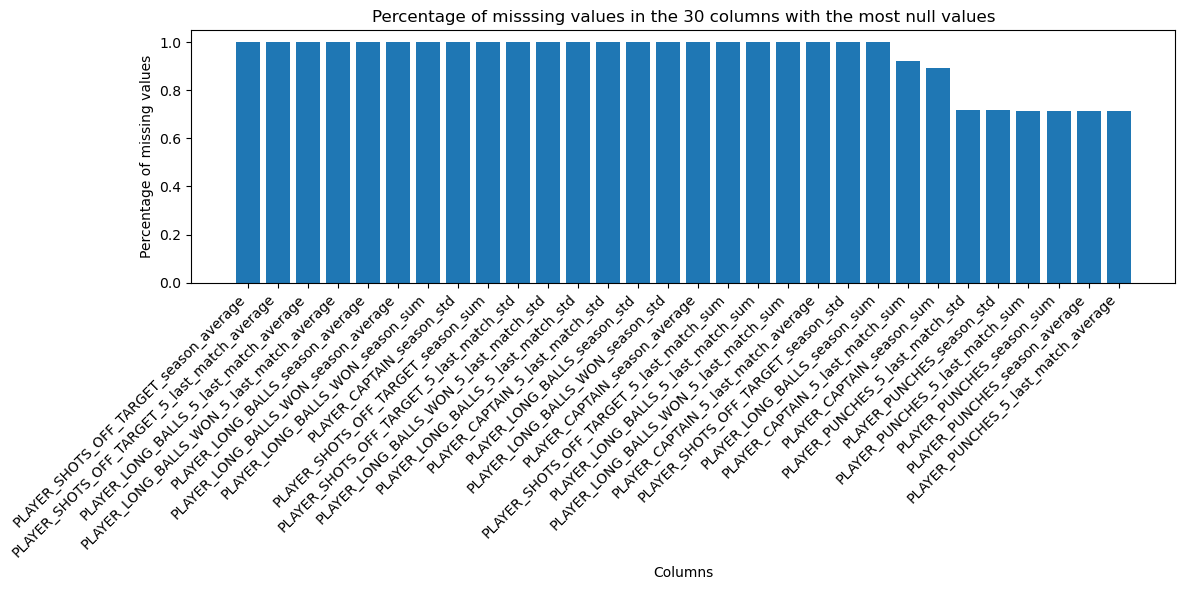

In [39]:
top30_misv = column_missing_values_player_away.head(30)
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(top30_misv.index, top30_misv)
ax.set_xticklabels(top30_misv.index, rotation=45, ha='right')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of misssing values in the 30 columns with the most null values')
plt.tight_layout()
plt.show()

In [18]:
# Je vais effacer les colonnes ou on a plus de 30% des données manquant

columns_to_drop = column_missing_values_player_away[column_missing_values_player_away > 0.3].index
train_player_away_clean_col = train_player_away.drop(columns=columns_to_drop)
print('Shape initiale:', train_player_away.shape)
print('Shape finale:',train_player_away_clean_col.shape)

Shape initiale: (236132, 307)
Shape finale: (236132, 274)


Analyse sur les lignes

In [15]:
row_missing_values_player_away = train_player_away.isna().mean(axis=1).sort_values(ascending=False)
row_missing_values_player_away

71798     0.986971
71802     0.986971
172749    0.986971
76566     0.986971
172766    0.986971
            ...   
53448     0.071661
209631    0.071661
118052    0.071661
118048    0.071661
209693    0.071661
Length: 236132, dtype: float64

In [42]:
print(f'Percentage de colonnes avec de données manquantes: {len(row_missing_values_player_away[row_missing_values_player_away > 0])*100/len(row_missing_values_player_away):.3f} %')

Percentage de colonnes avec de données manquantes: 100.000 %


In [19]:
# je vais effacer toutes les lignes avec NaN sur 'POSITION'

print('Nombre des lignes avec "position" NaN:', train_player_away_clean_col['POSITION'].isnull().sum())

rows_to_drop = train_player_away_clean_col[train_player_away_clean_col['POSITION'].isnull()].index

train_player_away_clean = train_player_away_clean_col.drop(rows_to_drop)

print('Shape initiale:', train_player_away.shape)
print('Shape finale:',train_player_away_clean.shape)


Nombre des lignes avec "position" NaN: 42255
Shape initiale: (236132, 307)
Shape finale: (193877, 274)


APPLICATION DE LA PCA:
-   JE PEUX UTILISER QUE DES VARIABLES NUMERIQUES --> JE NE CONSIDERE PAS TOUTES LES COLONNES
-   J'UTILISE UN'IMPUTATION PAR MEDIANE (JE PEUX PAS AVOIR DES DONNEES MANQUANTS)
-   JE TROUVE LE NOMBRE DE COMPOSANTES PRINCIPALES QUI PRESERVENT LE 95% DE LA VARIANCE
-   J'AJOUTE CES COLONNES A LA TABLE INITIALE AVEC AUSSI LE VARIABLES CATEGORY --> POUR CHAQUE LIGNE J'AI DES COLONNES AVEC "UNE COMBINATION" DES LEUR DONNEES (LES COLONNES DE COMPOSANTES PRINCIPALES)




In [20]:
train_player_away_clean_values = train_player_away_clean.select_dtypes(include=[float, int])

train_player_away_clean_values_imputed = train_player_away_clean_values.apply(lambda x: x.fillna(x.median()))

scaler = StandardScaler()
train_player_away_scaled = scaler.fit_transform(train_player_away_clean_values_imputed)

pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(train_player_away_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

train_player_away_pca = pd.concat([train_player_away_clean.reset_index(drop=True), pca_df], axis=1)

print("Nombre des composantes principales pour garder le 95% de la variance:", pca.n_components_)


: 

In [46]:
print('Shape before pca:',train_player_away_clean.shape)
print('Shape after pca:',train_player_away_pca.shape)
train_player_away_pca.head()

Shape before pca: (193877, 274)
Shape after pca: (193877, 355)


,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81
0,0,Ligue 1,Olympique Marseille,defender,Lucas Perrin,0.0,19.0,20.0,0.0,0.0,...,-0.123964,-0.766023,0.315738,0.029929,0.547168,0.146836,0.819239,-0.263895,-0.655916,-0.436699
1,0,Ligue 1,Olympique Marseille,midfielder,Kevin Strootman,2.0,48.0,19.0,28.0,8.0,...,-0.479404,0.002442,-0.863135,0.707156,-0.574489,-0.694155,0.106473,0.771467,0.273532,-0.439240
2,0,Ligue 1,Olympique Marseille,goalkeeper,Yohann Pelé,0.0,0.0,0.0,0.0,0.0,...,0.183161,-0.034053,0.417293,-0.056078,-0.058584,-0.021642,0.596668,-0.160428,0.048395,0.248996
3,0,Ligue 1,Olympique Marseille,defender,Abdallah Ali Mohamed,0.0,0.0,0.0,0.0,0.0,...,0.255008,-0.496055,-1.456606,0.307054,0.419341,0.010448,-0.554847,-0.645506,0.112722,-0.489760
4,0,Ligue 1,Olympique Marseille,midfielder,Marley Aké,0.0,1.0,0.0,0.0,0.0,...,0.073434,-0.179949,0.315419,0.565311,-0.262276,0.155955,0.059574,-0.097702,0.362819,0.309204


In [14]:
# ragroupement par id et position (moyenne et dev standard des composantes de PCA)
pca_stats = train_player_away_pca.groupby(['ID', 'POSITION']).agg(
    **{f'mean_{col}': (col, 'mean') for col in train_player_away_pca.columns if col.startswith('PC')},
    **{f'var_{col}': (col, 'var') for col in train_player_away_pca.columns if col.startswith('PC')}
).reset_index()

pca_stats.head(n= 8)

# NOTE: pour certains match il y a pas toutes les 4 "poistion" 

,ID,POSITION,mean_PC1,mean_PC2,mean_PC3,mean_PC4,mean_PC5,mean_PC6,mean_PC7,mean_PC8,...,var_PC72,var_PC73,var_PC74,var_PC75,var_PC76,var_PC77,var_PC78,var_PC79,var_PC80,var_PC81
0,0,defender,4.850005,4.080571,-1.574483,0.483125,2.096281,-1.544629,0.604405,1.432392,...,0.051308,0.078984,0.496656,0.439521,0.088234,0.562029,0.439874,0.048441,0.512415,0.683523
1,0,goalkeeper,-11.843819,0.255226,7.944568,0.080993,-0.484155,-1.815829,-0.684290,0.805843,...,0.013619,0.200264,0.007407,0.006618,0.106881,0.162280,0.220712,0.342013,0.069945,0.150408
2,0,midfielder,1.687971,-0.584745,-1.216991,0.203801,1.075415,-1.519742,2.239562,-0.830553,...,0.248325,0.166605,0.346453,0.545593,0.130514,0.131642,0.168194,0.659337,0.063166,0.115784
3,1,defender,0.101052,5.611335,-0.944582,-0.541570,-0.592965,1.166666,-0.177340,0.636253,...,0.280174,0.554395,0.166800,0.136610,0.715555,0.166127,0.251416,0.388106,0.182078,0.474733
4,1,goalkeeper,-12.191812,1.752915,11.802328,0.457552,1.728019,2.314667,-0.069129,-0.714804,...,0.123491,0.068839,0.000005,0.011301,0.116916,0.326806,0.065315,0.452392,0.007109,0.353325
5,1,midfielder,5.934687,-0.044099,-0.480478,0.945387,2.685326,0.205704,1.494279,0.741236,...,0.536994,0.454958,0.284924,0.647842,0.400093,0.260572,0.237720,0.101600,0.082646,1.433161
6,2,attacker,11.285721,-7.773620,1.841005,1.084977,0.573333,1.027816,-1.596818,1.256412,...,0.073299,0.144342,0.253641,2.007205,0.348838,0.048411,0.557753,0.295968,0.359175,0.384998
7,2,defender,1.787496,5.011463,-1.409607,-0.531011,-0.873519,-1.126605,0.261762,2.819988,...,0.163452,0.211621,0.450769,0.314575,0.117751,0.286187,0.507798,0.064347,0.119901,0.458052


In [15]:
mean_columns = [col for col in pca_stats.columns if col.startswith("mean_PC")]
var_columns = [col for col in pca_stats.columns if col.startswith("var_PC")]

all = []

for id_value in pca_stats['ID'].unique():
    
    filtered_data = pca_stats[pca_stats['ID'] == id_value]
    
    result = {'ID': id_value}

    for position, group in filtered_data.groupby('POSITION'):
        for i, (mean_col, var_col) in enumerate(zip(mean_columns, var_columns)):
            result[f"AWAY_{position}_PCA{i+1}_mean"] = group[mean_col].values[0]  
            result[f"AWAY_{position}_PCA{i+1}_var"] = group[var_col].values[0]  

    all.append(result)

final_train_player_away = pd.DataFrame(all)

final_train_player_away.head()


,ID,AWAY_defender_PCA1_mean,AWAY_defender_PCA1_var,AWAY_defender_PCA2_mean,AWAY_defender_PCA2_var,AWAY_defender_PCA3_mean,AWAY_defender_PCA3_var,AWAY_defender_PCA4_mean,AWAY_defender_PCA4_var,AWAY_defender_PCA5_mean,...,AWAY_attacker_PCA77_mean,AWAY_attacker_PCA77_var,AWAY_attacker_PCA78_mean,AWAY_attacker_PCA78_var,AWAY_attacker_PCA79_mean,AWAY_attacker_PCA79_var,AWAY_attacker_PCA80_mean,AWAY_attacker_PCA80_var,AWAY_attacker_PCA81_mean,AWAY_attacker_PCA81_var
0,0,4.850005,69.726648,4.080571,25.510114,-1.574483,6.126837,0.483125,7.379253,2.096281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.101052,21.724201,5.611335,19.095460,-0.944582,6.865555,-0.541570,5.082745,-0.592965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.787496,97.172620,5.011463,50.717744,-1.409607,0.647587,-0.531011,12.802909,-0.873519,...,-0.329555,0.048411,0.025704,0.557753,0.558136,0.295968,-0.166443,0.359175,-0.591404,0.384998
3,3,2.184010,56.656887,3.650309,35.595522,-0.927539,4.703874,0.483055,25.967457,0.026481,...,-0.152221,0.628898,-0.573151,0.389242,-0.446933,1.434726,0.543107,0.121352,-0.150287,0.330742
4,4,2.587049,92.299188,3.553529,37.726074,-0.850497,1.999878,-0.744709,12.510813,-1.537177,...,0.011132,2.110919,-0.144402,0.024381,-0.050752,0.066018,0.572869,0.015713,0.427069,0.106371


**Train_player_home**

In [49]:
train_player_home.head()

,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PLAYER_STARTING_LINEUP_5_last_match_std,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std,PLAYER_TACKLES_5_last_match_std,PLAYER_TOTAL_CROSSES_5_last_match_std,PLAYER_TOTAL_DUELS_5_last_match_std,PLAYER_YELLOWCARDS_5_last_match_std,PLAYER_PUNCHES_5_last_match_std,PLAYER_LONG_BALLS_5_last_match_std,PLAYER_LONG_BALLS_WON_5_last_match_std,PLAYER_SHOTS_OFF_TARGET_5_last_match_std
0,0,Ligue 1,Toulouse,defender,Agustín Rogel,0.0,8.0,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Ligue 1,Toulouse,defender,Mathieu Goncalves,0.0,7.0,4.0,0.0,0.0,...,63.0,14.0,13.0,0.0,36.0,77.0,NaN,NaN,NaN,NaN
2,0,Ligue 1,Toulouse,goalkeeper,Baptiste Reynet,0.0,33.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN
3,0,Ligue 1,Toulouse,midfielder,Jean-Victor Makengo,8.0,27.0,2.0,0.0,8.0,...,63.0,0.0,13.0,6.0,17.0,0.0,NaN,NaN,NaN,NaN
4,0,Ligue 1,Toulouse,NaN,Efthymios Koulouris,2.0,23.0,27.0,14.0,8.0,...,63.0,17.0,10.0,13.0,27.0,0.0,NaN,NaN,NaN,NaN


In [50]:
print('dimension of dataset:', train_player_home.shape)

dimension of dataset: (237079, 307)


In [51]:
train_player_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237079 entries, 0 to 237078
Columns: 307 entries, ID to PLAYER_SHOTS_OFF_TARGET_5_last_match_std
dtypes: float64(302), int64(1), object(4)
memory usage: 555.3+ MB


In [52]:
# numero des équipes, leagues et jouers

teams = train_player_home['TEAM_NAME'].unique()
print(f"Número d'équipes: {len(teams)}")
leagues = train_player_home['LEAGUE'].unique()
print(f'Número de leagues: {len(leagues)}')
players = train_player_home['PLAYER_NAME'].unique()
print(f'Número de jouers des teams: {len(players)}')

Número d'équipes: 350
Número de leagues: 13
Número de jouers des teams: 13551


Analyse sur les colonnes

In [5]:
column_missing_values_player_home = train_player_home.isna().mean().sort_values(ascending=False)
column_missing_values_player_home

PLAYER_SHOTS_OFF_TARGET_season_average          1.000000
PLAYER_SHOTS_OFF_TARGET_5_last_match_average    1.000000
PLAYER_LONG_BALLS_5_last_match_average          1.000000
PLAYER_LONG_BALLS_WON_5_last_match_average      1.000000
PLAYER_LONG_BALLS_season_average                1.000000
                                                  ...   
PLAYER_GOALS_season_average                     0.015172
PLAYER_NAME                                     0.000000
TEAM_NAME                                       0.000000
LEAGUE                                          0.000000
ID                                              0.000000
Length: 307, dtype: float64

In [54]:
print(f'Percentage de colonnes avec de données manquantes: {len(column_missing_values_player_home[column_missing_values_player_home > 0])*100/len(column_missing_values_player_home):.3f} %')

Percentage de colonnes avec de données manquantes: 98.697 %


/tmp/ipykernel_74929/4820469.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top30_misv.index, rotation=45, ha='right')


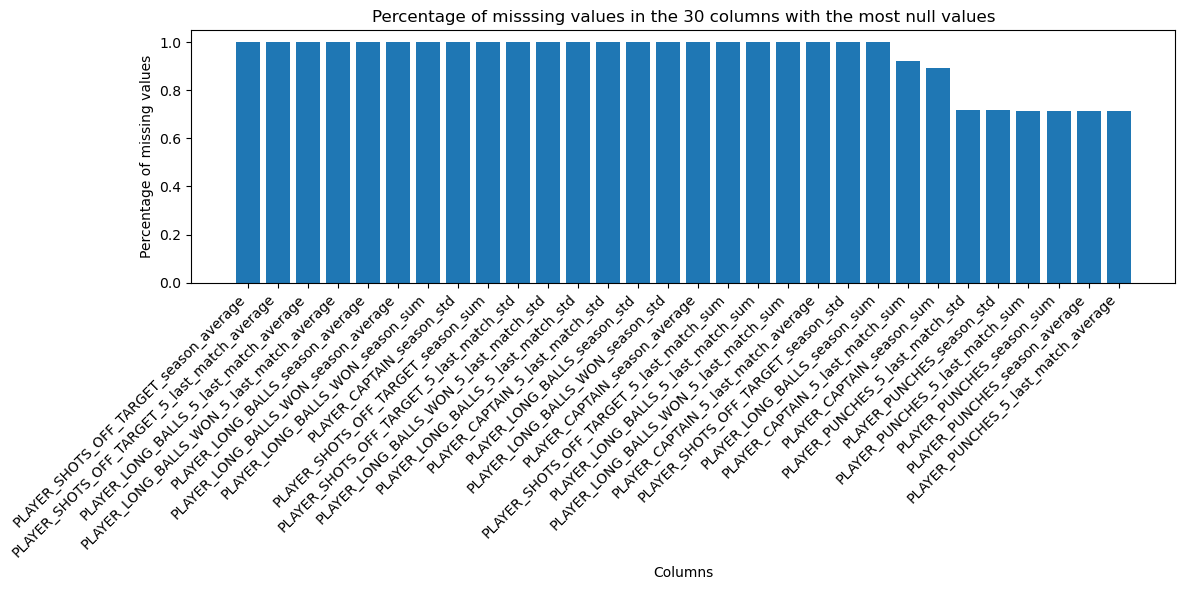

In [55]:
top30_misv = column_missing_values_player_home.head(30)
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(top30_misv.index, top30_misv)
ax.set_xticklabels(top30_misv.index, rotation=45, ha='right')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of misssing values in the 30 columns with the most null values')
plt.tight_layout()
plt.show()

In [6]:
# Je vais effacer les colonnes ou on a plus de 30% des données manquant

columns_to_drop = column_missing_values_player_home[column_missing_values_player_home > 0.3].index
train_player_home_clean_col = train_player_home.drop(columns=columns_to_drop)
print('Shape initiale:', train_player_home.shape)
print('Shape finale:',train_player_home_clean_col.shape)

Shape initiale: (237079, 307)
Shape finale: (237079, 274)


Analyse sur les lignes

In [7]:
row_missing_values_player_home = train_player_home.isna().mean(axis=1).sort_values(ascending=False)
row_missing_values_player_home

211935    0.986971
55251     0.986971
186845    0.986971
77505     0.986971
93809     0.986971
            ...   
73338     0.071661
73337     0.071661
203938    0.071661
8268      0.071661
73592     0.071661
Length: 237079, dtype: float64

In [58]:
print(f'Percentage de colonnes avec de données manquantes: {len(row_missing_values_player_home[row_missing_values_player_home > 0])*100/len(row_missing_values_player_home):.3f} %')

Percentage de colonnes avec de données manquantes: 100.000 %


In [8]:
# je vais effacer toutes les lignes avec NaN sur 'POSITION'

print('Nombre des lignes avec "position" NaN:', train_player_home_clean_col['POSITION'].isnull().sum())

rows_to_drop = train_player_home_clean_col[train_player_home_clean_col['POSITION'].isnull()].index

train_player_home_clean = train_player_home_clean_col.drop(rows_to_drop)

print('Shape initiale:', train_player_home.shape)
print('Shape finale:',train_player_home_clean.shape)


Nombre des lignes avec "position" NaN: 42820
Shape initiale: (237079, 307)
Shape finale: (194259, 274)


In [9]:
train_player_home_clean_values = train_player_home_clean.select_dtypes(include=[float, int])

train_player_home_clean_values_imputed = train_player_home_clean_values.apply(lambda x: x.fillna(x.median()))

scaler = StandardScaler()
train_player_home_scaled = scaler.fit_transform(train_player_home_clean_values_imputed)

pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(train_player_home_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

train_player_home_pca = pd.concat([train_player_home_clean.reset_index(drop=True), pca_df], axis=1)

print("Nombre des composantes principales pour garder le 95% de la variance:", pca.n_components_)

Nombre des composantes principales pour garder le 95% de la variance: 81


In [17]:
print('Shape before pca:',train_player_home_clean.shape)
print('Shape after pca:',train_player_home_pca.shape)
train_player_home_pca.head()

Shape before pca: (194259, 274)
Shape after pca: (194259, 355)


,ID,LEAGUE,TEAM_NAME,POSITION,PLAYER_NAME,PLAYER_ACCURATE_CROSSES_season_sum,PLAYER_ACCURATE_PASSES_season_sum,PLAYER_AERIALS_WON_season_sum,PLAYER_ASSISTS_season_sum,PLAYER_BIG_CHANCES_CREATED_season_sum,...,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81
0,0,Ligue 1,Toulouse,defender,Agustín Rogel,0.0,8.0,5.0,0.0,0.0,...,1.613240,-0.438641,-0.611793,0.466935,0.804468,0.314984,0.493470,-1.494505,0.212418,-0.519935
1,0,Ligue 1,Toulouse,defender,Mathieu Goncalves,0.0,7.0,4.0,0.0,0.0,...,0.520227,0.475323,-0.530391,0.626761,0.590245,-0.648571,0.348240,-0.148168,-0.006532,0.637509
2,0,Ligue 1,Toulouse,goalkeeper,Baptiste Reynet,0.0,33.0,2.0,0.0,0.0,...,0.343322,-0.309963,0.020777,0.023829,0.099930,-0.045352,0.280426,-0.172668,-0.332160,0.412126
3,0,Ligue 1,Toulouse,midfielder,Jean-Victor Makengo,8.0,27.0,2.0,0.0,8.0,...,-0.029405,-0.001264,-0.115279,0.241572,-0.130465,-0.802752,0.621628,0.050532,0.116092,0.733164
4,0,Ligue 1,Toulouse,midfielder,Ibrahim Sangaré,0.0,44.0,26.0,14.0,8.0,...,-0.361066,0.527078,-0.262033,0.100337,-0.660426,-0.318541,0.119783,-1.035457,1.293304,0.440745


In [10]:
# ragroupement par id et position (moyenne et dev standard des composantes de PCA)
pca_stats = train_player_home_pca.groupby(['ID', 'POSITION']).agg(
    **{f'mean_{col}': (col, 'mean') for col in train_player_home_pca.columns if col.startswith('PC')},
    **{f'var_{col}': (col, 'var') for col in train_player_home_pca.columns if col.startswith('PC')}
).reset_index()

pca_stats.head(n= 8)


,ID,POSITION,mean_PC1,mean_PC2,mean_PC3,mean_PC4,mean_PC5,mean_PC6,mean_PC7,mean_PC8,...,var_PC72,var_PC73,var_PC74,var_PC75,var_PC76,var_PC77,var_PC78,var_PC79,var_PC80,var_PC81
0,0,defender,2.159041,4.827786,-1.363626,-0.024691,-0.145935,-0.480079,-0.463978,1.030596,...,0.304067,0.825392,0.094923,0.294338,0.648654,0.236352,0.198961,0.444645,0.133083,0.453149
1,0,goalkeeper,-12.303156,0.652580,9.797409,0.180201,-0.093822,-1.860995,0.102887,0.681008,...,0.000129,0.051251,0.331495,0.000062,0.014015,0.002312,0.243479,0.002417,0.041189,0.024417
2,0,midfielder,5.889276,-3.161724,-0.022349,1.502715,0.979185,-0.094091,2.060930,0.109787,...,0.461776,0.502074,0.121393,0.332322,0.723410,0.287549,0.140090,0.714657,0.574332,0.713378
3,1,defender,1.370469,5.669567,-0.505821,-1.524392,-2.687328,-2.287575,-0.643039,-0.003163,...,0.567593,0.694224,0.072385,0.290717,0.129151,0.213357,0.182954,0.019369,0.119948,0.158121
4,1,goalkeeper,-12.019961,-0.194496,7.931480,-0.060684,-0.349007,-2.305762,-0.270275,-0.455637,...,0.042789,0.188165,0.045198,0.001594,0.028249,0.149279,0.122882,0.028036,0.053520,0.047704
5,1,midfielder,3.365878,-2.948804,0.250676,-0.116541,0.059081,-1.120101,-0.002291,-0.311245,...,0.388941,0.280205,0.299338,0.608790,0.254744,0.349896,0.392871,0.253285,0.146985,0.402893
6,2,attacker,-3.426344,-4.493898,-1.805685,-2.446370,0.759828,1.962036,-0.663230,0.360094,...,0.106790,0.653962,0.750290,0.167046,0.241253,0.031754,0.206542,0.250101,0.702251,0.465542
7,2,defender,0.346264,4.456673,-2.703146,-0.095952,-0.379001,2.866405,0.132832,1.970962,...,0.374588,0.494929,0.530715,0.499659,0.578881,0.201675,0.149016,0.409346,0.397043,0.125967


In [11]:
mean_columns = [col for col in pca_stats.columns if col.startswith("mean_PC")]
var_columns = [col for col in pca_stats.columns if col.startswith("var_PC")]

all = []

for id_value in pca_stats['ID'].unique():
    
    filtered_data = pca_stats[pca_stats['ID'] == id_value]
    
    result = {'ID': id_value}

    for position, group in filtered_data.groupby('POSITION'):
        for i, (mean_col, var_col) in enumerate(zip(mean_columns, var_columns)):
            result[f"HOME_{position}_PCA{i+1}_mean"] = group[mean_col].values[0]  
            result[f"HOME_{position}_PCA{i+1}_var"] = group[var_col].values[0]  

    all.append(result)

final_train_player_home = pd.DataFrame(all)

final_train_player_home.head()

,ID,HOME_defender_PCA1_mean,HOME_defender_PCA1_var,HOME_defender_PCA2_mean,HOME_defender_PCA2_var,HOME_defender_PCA3_mean,HOME_defender_PCA3_var,HOME_defender_PCA4_mean,HOME_defender_PCA4_var,HOME_defender_PCA5_mean,...,HOME_attacker_PCA77_mean,HOME_attacker_PCA77_var,HOME_attacker_PCA78_mean,HOME_attacker_PCA78_var,HOME_attacker_PCA79_mean,HOME_attacker_PCA79_var,HOME_attacker_PCA80_mean,HOME_attacker_PCA80_var,HOME_attacker_PCA81_mean,HOME_attacker_PCA81_var
0,0,2.159041,38.925666,4.827786,16.783137,-1.363626,2.568429,-0.024691,9.501891,-0.145935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.370469,50.441771,5.669567,16.912044,-0.505821,3.833278,-1.524392,6.101149,-2.687328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.346264,40.531904,4.456673,13.800305,-2.703146,1.124305,-0.095952,8.822019,-0.379001,...,-0.289033,0.031754,-0.480388,0.206542,0.050749,0.250101,0.387933,0.702251,-0.434622,0.465542
3,3,-0.560533,62.872149,7.121700,58.945885,-0.786692,1.095985,-1.939397,3.392200,-2.818796,...,-0.200621,0.248351,0.191149,0.072574,0.936565,0.931067,0.431992,0.135685,-0.097101,0.040998
4,4,-2.629586,72.453143,4.109058,40.590342,-1.740056,3.010218,-1.234224,4.928775,-1.982564,...,-0.419882,0.928947,0.799351,0.064914,-0.338798,0.573658,1.018597,0.219837,0.439596,0.559686


In [12]:
# merge tableau obtenue à partir de player
train_player = pd.merge(final_train_player_home, final_train_player_away, on = 'ID', how = 'inner')
train_player.head()


NameError: name 'final_train_player_away' is not defined

Merge des tableaux teams et joueurs

In [ ]:
train_final = pd.merge(train_team, train_player, on = 'ID', how = 'inner')
train_final.to_csv('train_final.csv', index=False)
train_final.head()